## Estimation Example



In this document we&rsquo;ll work through a simple approach to estimating
Constant Frisch Elasticity (CFE) demand systems.

There are two prerequisites; the first is the `CFEDemands` python
module.  You may have this already, but if not it  can be installed with a simple:



In [5]:
!pip install -r requirements.txt

The second prerequisite is a dataset including detailed information on
household expenditures and characteristics.  The structure of that
dataset is detailed in the next section.



### Data



Consider the case in which the data are saved in a google sheet; we&rsquo;ll
turn data from these into `pandas` dataframes.
There are limits on the allowable size of google sheets (5 million
cells when I last checked), so if your dataset is larger than this you&rsquo;ll need some other
mechanism to get your data into such dataframes.  Even in this latter
case you&rsquo;ll want your dataframes to have a structure that matches the
description given below.



#### Structure of the Spreadsheet



An example spreadsheet with data for Uganda can be found at
[https://docs.google.com/spreadsheets/d/1yFWlP5N7Aowaj6t2roRSFFUC50aFD-RLBGfzGtqLl0w/](https://docs.google.com/spreadsheets/d/1yFWlP5N7Aowaj6t2roRSFFUC50aFD-RLBGfzGtqLl0w/)

This spreadsheet consists of several worksheets, labeled &ldquo;RDI&rdquo;, &ldquo;FCT&rdquo;,
&ldquo;Household Characteristics&rdquo;, and a series of different years of food expenditures and prices

Most worksheets have the initial three columns labeled &ldquo;i&rdquo;, &ldquo;t&rdquo;, and
&ldquo;m&rdquo;; together these identify an observation uniquely.  The column &ldquo;i&rdquo;
should include a household id; the column &ldquo;t&rdquo; should include an
indicator for the year or period (for those of you with
cross-sectional data these will all take a common value, e.g., 2019);
the column &ldquo;m&rdquo; should be an indicator of &ldquo;market&rdquo;, which may be a
region identifier, or may take a single value (e.g., &ldquo;Uganda&rdquo;).

The triple (i,t,m) will serve as the index of some constructed
dataframes.  It is important not to have **too** many different values
for &ldquo;m&rdquo; (unless you have lots of data and RAM to play with).

Beyond the first three columns, the &ldquo;Expenditures&rdquo; worksheet for a given year should have one index (or alternatively, one column) for each category of expenditures (e.g., &ldquo;Beans&rdquo;, &ldquo;Beef&rdquo;, &ldquo;Beer&rdquo;,&#x2026;).

Beyond the first three columns, the &ldquo;Household Characteristics&rdquo; should
have columns corresponding to different elements of the vector of
observable characteristics $z$.  If the data permit, I recommend
constructing observables that match what I have in these data:
namely numbers of different children by age and sex, along with the
logarithm of total household size (&ldquo;log HSize&rdquo;).



#### From Sheet to DataFrame to Regression Object



We begin by defining a dictionary that contains the spreadsheet key.
One is provided for the Ugandan example that I wish to work
through.



In [6]:
#Uganda_Data = '1yFWlP5N7Aowaj6t2roRSFFUC50aFD-RLBGfzGtqLl0w'
Senegal_Data = '1FrCW6vIbpHx9jDfo2tBugmkUn5XoO-j5vE2Z5dLgU0E'

With the spreadsheet defined , grab it and define a couple of
dataframes. (Sheets should be shared with `students@eep153.iam.gserviceaccount.com`):



In [18]:
import pandas as pd
import numpy as np
from eep153_tools.sheets import read_sheets

# Change 'Uganda_Data' to key of your own sheet in Sheets, above
x = read_sheets(Senegal_Data,sheet='Food Expenditures (2019)')
x = x.set_index(['i','t','m','j']).squeeze()
x.to_csv('Food_Expenditures(2019).csv')
x



i      t     m           j                         
21001  2019  ziguinchor  Ail                             25.0
                         Beurre                          75.0
                         Café                            75.0
                         Carotte                        100.0
                         Choux                           50.0
                                                        ...  
2989   2019  ziguinchor  Sucre (poudre ou morceaux)     500.0
                         Thé                            100.0
                         Tomate fraîche                 100.0
                         Viande de b__uf               1200.0
                         Vinaigre /moutarde              25.0
Name: Expenditure, Length: 93749, dtype: float64

In [10]:
# Now prices
p = read_sheets(Senegal_Data,sheet='Food Prices (2019)').set_index(['t','m','j','u'])

# Compute medians of prices for particular time, place and unit
p = p.groupby(['t','m','j','u']).median()

# Just keep metric units
p = p.xs('Kg',level="u").squeeze().unstack('j')

# Drop prices for goods we don't have expenditures for
#p = p[x.index.levels[-1]].T
valid_foods = x.index.get_level_values('j').unique()

# Filter the price dataset to only include valid foods
p = p.loc[:, p.columns.isin(valid_foods)]
p

j                 Abats et tripes (foie, rognon, etc.)     Ail  \
t    m                                                           
2019 SAINT-LOUIS                                3000.0  1000.0   
     dakar                                      2400.0  1000.0   
     diourbel                                   1600.0  1050.0   
     fatick                                     1200.0  1300.0   
     kaffrine                                   3000.0  1150.0   
     kaolack                                    3000.0   800.0   
     kedougou                                   4000.0  1100.0   
     kolda                                         NaN  2800.0   
     louga                                      1750.0  1000.0   
     matam                                         NaN   650.0   
     sedhiou                                       NaN  1250.0   
     tambacounda                                   NaN  1500.0   
     thies                                      3600.0  1060.0   
     ziguinchor                                 1000.0     NaN   

j                 Arachide grillée  \
t    m                               
2019 SAINT-LOUIS               NaN   
     dakar                     NaN   
     diourbel                  NaN   
     fatick                  800.0   
     kaffrine                400.0   
     kaolack                   NaN   
     kedougou                  NaN   
     kolda                     NaN   
     louga                     NaN   
     matam                     NaN   
     sedhiou                 600.0   
     tambacounda               NaN   
     thies                     NaN   
     ziguinchor                NaN   

j                 Arachides décortiquées ou pilées (noflaye)  \
t    m                                                         
2019 SAINT-LOUIS                                       600.0   
     dakar                                             800.0   
     diourbel                                          700.0   
     fatick                                            450.0   
     kaffrine                                          500.0   
     kaolack                                           400.0   
     kedougou                                          600.0   
     kolda                                             600.0   
     louga                                             550.0   
     matam                                             700.0   
     sedhiou                                           600.0   
     tambacounda                                       500.0   
     thies                                             800.0   
     ziguinchor                                          NaN   

j                 Arachides fraîches en coques  Arachides séchées en coques  \
t    m                                                                        
2019 SAINT-LOUIS                           NaN                          NaN   
     dakar                                 NaN                        700.0   
     diourbel                              NaN                          NaN   
     fatick                                NaN                       1000.0   
     kaffrine                              NaN                        300.0   
     kaolack                             600.0                        750.0   
     kedougou                              NaN                        250.0   
     kolda                               525.0                          NaN   
     louga                                 NaN                          NaN   
     matam                                 NaN                        600.0   
     sedhiou                               NaN                          NaN   
     tambacounda                           NaN                        350.0   
     thies                                 NaN                          NaN   
     ziguinchor                            NaN                        800.0   

j                 Aubergine, Courge/Courgett

In [12]:
# Household characteristics
d = read_sheets(Senegal_Data,sheet="Household Characteristics")
d.columns.name = 'k'

# Fill blanks with zeros
d = d.replace(np.nan,0)

# Expenditures x may have duplicate columns
x = x.T.groupby(['i','t','m','j']).sum()
x = x.replace(0,np.nan) # Replace zeros with missing

# Take logs of expenditures; call this y
y = np.log(x)

d.set_index(['i','t','m'],inplace=True)

This gives a dataframe of household characteristics $d$ with a simple structure.



In [13]:
d.head()

,,k,women,girls,boys,men,Males 00-03,Females 00-03,Males 04-08,Females 04-08,Males 09-13,Females 09-13,Males 14-18,Females 14-18,Males 19-30,Females 19-30,Males 31-50,Females 31-50,Males 51-99,Females 51-99,log HSize
i,t,m,,,,,,,,,,,,,,,,,,,
11011,2018,ziguinchor,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.000000
110110,2018,ziguinchor,1,1,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1.386294
110111,2018,ziguinchor,0,0,2,2,0,0,0,0,0,0,2,0,1,0,1,0,0,0,1.386294
110112,2018,ziguinchor,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0.693147
11012,2018,ziguinchor,2,4,2,2,0,0,0,1,1,1,1,2,1,1,0,1,1,0,2.302585


Also a dataframe of log expenditures $y$ with a similarly simple
structure.  Note that any expenditures of zero are dropped and
replaced with a missing value indicator.



In [14]:
y.head()

i    t     m      j                                                                  
221  2019  dakar  Abats et tripes (foie, rognon, etc.)                                   7.600902
                  Ail                                                                    4.605170
                  Arachides décortiquées ou pilées (noflaye)                             6.214608
                  Aubergine, Courge/Courgette                                            4.605170
                  Autre légumes frais n.d.a (y compris les fleurs blanches de bissap)    3.912023
Name: Expenditure, dtype: float64

### Estimation



Let $y_{i}^j$ be log expenditures on food $j$ by household $i$ at a particular time.  We want to estimate a regression that takes the form
$$
      y^j_{i} = A^j(p) + \gamma_j'd_i + \beta_j w_i + \zeta^j_i.
$$
We have data on `y` (log expenditures) and `d` (household characteristics).  This leaves the rest of the elements for us to estimate.



#### Basic Estimation



Just one line to set up the regression:



In [15]:
from cfe import Regression

result = Regression(y=y,d=d)

And then one line to predict expenditures and estimate most of the things we need:



In [16]:
result.predicted_expenditures()

i       t     m        j                                                                  
221     2019  dakar    Ail                                                                     162.631405
                       Arachides décortiquées ou pilées (noflaye)                              371.838707
                       Aubergine, Courge/Courgette                                             123.066420
                       Autre légumes frais n.d.a (y compris les fleurs blanches de bissap)     166.746810
                       Autres condiments (poivre etc.)                                         148.382966
                                                                                                 ...     
259812  2019  sedhiou  Thé                                                                     145.420446
                       Tomate fraîche                                                          135.910504
                       Viande de b__uf                       

Now we can compare predicted log expenditures with actual:



<Axes: xlabel='yhat', ylabel='y'>

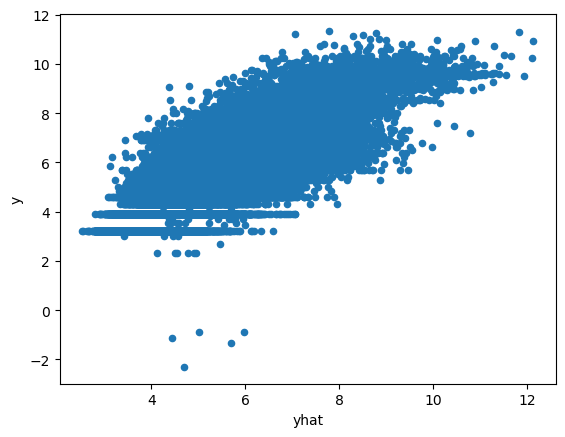

In [17]:
%matplotlib inline
df = pd.DataFrame({'y':y,'yhat':result.get_predicted_log_expenditures()})
df.plot.scatter(x='yhat',y='y')

That&rsquo;s all there is to estimation!  Note that we didn&rsquo;t estimate
demands for all goods&#x2014;lots of goods didn&rsquo;t have enough observations,
and were automatically dropped.



#### Parameters



##### (Relative) Income Elasticity



Some of the parameters have an interesting interpretation.  First among these are the $\beta$ coefficients, which govern how *income elastic* different goods are (higher values means more elastic).  These are also called *Frisch elasticities*.
Here we use a plot to visualize, with confidence intervals.



In [1]:
ax = result.graph_beta()

To just see the values of $\beta$:



In [1]:
result.get_beta()

##### Demand and Household Composition



We&rsquo;re particularly interested in the effects of household composition on demand.  These are captured by the $\gamma_j$ parameters in the regression.



In [1]:
result.get_gamma()

##### Welfare



Another import quantity we estimate is $w_i$.  This is a welfare measure for the household.  Here&rsquo;s a histogram:



In [1]:
ax = result.get_w().plot.hist(bins=100,density=True)
result.get_w().plot.kde(ax=ax)

#### Saving Result



You can save the estimated result, using something like



In [1]:
result.to_pickle('uganda_estimates.rgsn')

You can subsequently load this using



In [1]:
import cfe
result = cfe.regression.read_pickle('uganda_estimates.rgsn')

#### Demand and Utility



Having estimated the demand system, we can examine the implied demand curves.



##### Budgets



Get food budget for all households, then find median budget:



In [1]:
import numpy as np

xhat = result.predicted_expenditures()

# Total food expenditures per household
xbar = xhat.groupby(['i','t','m']).sum()

# Reference budget
xref = xbar.quantile(0.5)  # Household at 0.5 quantile is median

##### Reference Prices



Choose reference prices.  Here we&rsquo;ll choose a particular year, and average prices across markets.  If you wanted to focus on particular market you&rsquo;d do this differently.



In [1]:
# Reference prices chosen from a particular time; average across place.
# These are prices per kilogram:
pbar = p.mean(axis=1)
pbar = pbar[result.beta.index] # Only use prices for goods we can estimate

# Replace missing prices with 1 (this is because they're best measured in expenditures)
pbar = pbar.replace(np.nan,1)

#Finally, define a function to change a single price in the vector $p$:
def my_prices(p0,j,p=pbar):
    """
    Change price of jth good to p0, holding other prices fixed.
    """
    p = p.copy()
    p.loc[j] = p0
    return p

##### Demand as a function of prices



Let&rsquo;s take a look at demand schedules for households with different budgets.



In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

use = 'Millet Flour'  # Good we want demand curve for

# Vary prices from 50% to 200% of reference.
scale = np.linspace(.5,2,20)

# Demand for Millet for household at median budget
plt.plot([result.demands(xref,my_prices(pbar[use]*s,use,pbar))[use] for s in scale],scale)

# Demand for Millet for household at 25% percentile
plt.plot([result.demands(xbar.quantile(0.25),my_prices(pbar[use]*s,use,pbar))[use] for s in scale],scale)

# Demand for Millet for household at 75% percentile
plt.plot([result.demands(xbar.quantile(0.75),my_prices(pbar[use]*s,use,pbar))[use] for s in scale],scale)

plt.ylabel(f"Price (relative to base of {pbar[use]:.2f})")
plt.xlabel(f"Quantities of {use} Demanded")

##### Engel Curves



Engel curves trace out how demand changes with budget:



In [1]:
fig,ax = plt.subplots()

ax.plot(np.log(scale*xref),[result.expenditures(s*xref,pbar)/(s*xref) for s in scale])
ax.set_xlabel(f'log budget (relative to base of {xref:.0f}')
ax.set_ylabel(f'Expenditure share')
ax.set_title('Engel Curves')

##### Indirect Utility



We can also describe an indirect utility function that corresponds to these demands:



In [1]:
fig,ax = plt.subplots()

ax.plot(scale*xref,[result.indirect_utility(s*xref,pbar) for s in scale])
ax.set_xlabel(f'Indirect Utility (Budget relative to base of {xref:.0f}')
ax.set_ylabel(f'Utility')
ax.set_title('Indirect Utility Function')